# lidar data from the Lunar Reconnaissance Orbiter (LRO) Lunar Orbiter Laser Altimeter (LOLA) within bounds `(127, 86, 139, 87)`

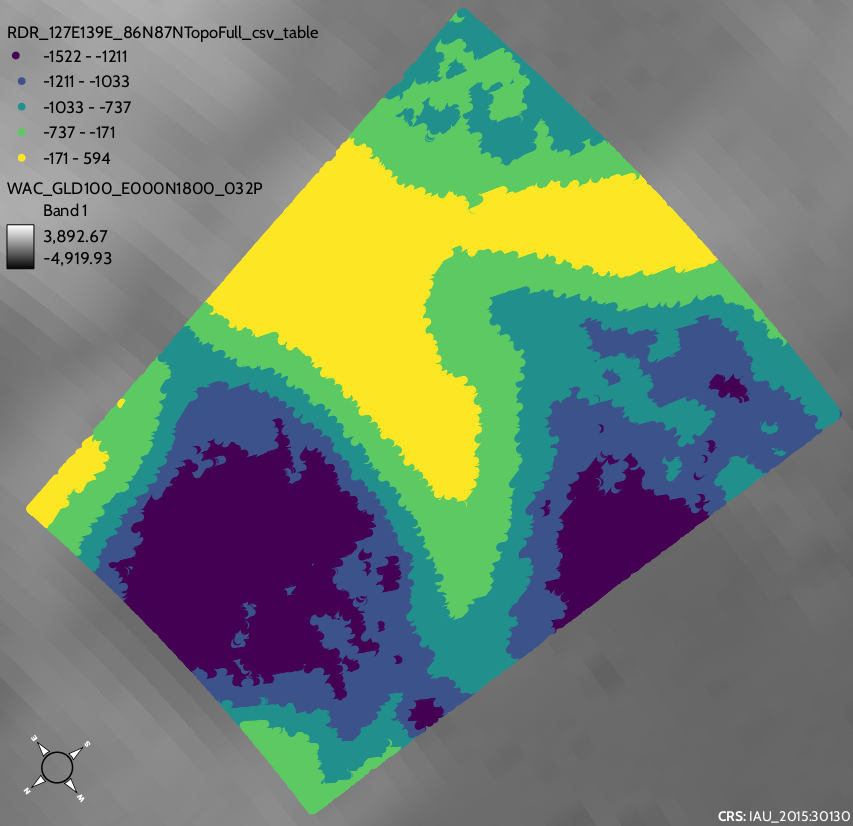

In [17]:
from IPython.core.display import Image

Image('image/lro_lola_crater.png')

In [18]:
from pathlib import Path

import geopandas
import numpy
import pandas
from Terrain_Trees import PointRegionTree
from geopandas import GeoDataFrame
from matplotlib import pyplot
from pyproj import CRS
from scipy.spatial import Delaunay

In [19]:
data_directory = Path('/home/zrb/Data/doctoral/')

In [20]:
crs = CRS.from_string('IAU_2015:30100')
crs

<Geographic 2D CRS: IAU_2015:30100>
Name: Moon (2015) - Sphere / Ocentric
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: Moon (2015) - Sphere
- Ellipsoid: Moon (2015) - Sphere
- Prime Meridian: Reference Meridian

In [21]:
input_filename = data_directory / 'RDR_127E139E_86N87NPointPerRow_csv_table' / 'RDR_127E139E_86N87NTopoFull_csv_table.csv'

data = pandas.read_csv(
    input_filename,
    parse_dates=['Coordinated_Universal_Time  '],
)
data = GeoDataFrame(
    data,
    geometry=geopandas.points_from_xy(
        data['Pt_Longitude'],
        data[' Pt_Latitude'],
        crs=crs,
    ),
    crs=crs,
)
data

,Pt_Longitude,Pt_Latitude,topography,Coordinated_Universal_Time,S,geometry
0,138.992241,86.049482,-749.15,2009-09-09 01:10:17.504561310,2,POINT (138.99224 86.04948)
1,138.945273,86.075387,-791.89,2009-09-09 01:10:18.075990020,2,POINT (138.94527 86.07539)
2,138.986849,86.088879,-831.57,2009-09-09 01:10:18.397419150,3,POINT (138.98685 86.08888)
3,138.939389,86.090334,-830.16,2009-09-09 01:10:18.468847570,1,POINT (138.93939 86.09033)
4,138.894922,86.090164,-828.65,2009-09-09 01:10:18.504561360,5,POINT (138.89492 86.09016)
...,...,...,...,...,...,...
747419,127.109142,86.996596,-515.73,2011-12-11 04:36:06.160639410,4,POINT (127.10914 86.99660)
747420,127.111252,86.997422,-507.11,2011-12-11 04:36:06.196353200,3,POINT (127.11125 86.99742)
747421,127.130373,86.998122,-505.91,2011-12-11 04:36:06.196353200,4,POINT (127.13037 86.99812)
747422,127.132494,86.998948,-497.16,2011-12-11 04:36:06.232068000,3,POINT (127.13249 86.99895)


<AxesSubplot:>

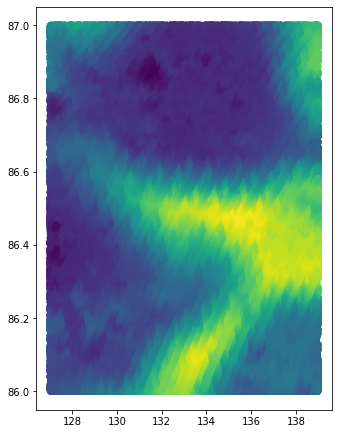

In [22]:
map_crs = CRS.from_string('IAU_2015:30130')
figure = pyplot.figure(figsize=(12, 12 / 1.61803398875))
axis = figure.add_subplot(1, 1, 1, transform=map_crs)
data.plot(column='topography ', ax=axis)

## build Delaunay triangulation

In [23]:
points = data[['Pt_Longitude', ' Pt_Latitude', 'topography ']].values
triangulation = Delaunay(points[:, :2])
triangulation.simplices

array([[680254, 341178, 649308],
       [488202, 419922, 132539],
       [419922, 543258, 132539],
       ...,
       [ 71468, 126563, 126568],
       [180045, 307563, 444997],
       [180045, 444997, 307568]], dtype=int32)

## write triangulation to `.tri` format

In [24]:
output_filename = data_directory / 'RDR_127E139E_86N87N.tri'

with open(output_filename, 'w') as output_file:
    output_file.write(f'{len(triangulation.points)}\n')
    numpy.savetxt(output_file, points, fmt='%f', delimiter=' ')
    output_file.write(f'{len(triangulation.simplices)}\n')
    numpy.savetxt(output_file, triangulation.simplices, fmt='%d', delimiter=' ')

## use `Terrain_Trees` library to read triangle mesh file

In [25]:
tree = PointRegionTree.from_file(
    str(output_filename),
    vertices_per_leaf=1,
    division_type=4,
)
tree

[NOTA] The points are embedded in a 3D space.
